# InfoBridge on image MI data


This notebook implements Image Benchmark experiment from Section 5.2 in [paper](https://arxiv.org/pdf/2502.01383)

Image benchmark is taken from [mutinfo library](https://github.com/VanessB/mutinfo)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms.functional as F

import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

from diffusers import UNet2DModel

from infobridge import InfoBridge

from mutinfo.distributions.base import CorrelatedUniform
from mutinfo.distributions.tools import mapped_multi_rv_frozen
from mutinfo.distributions.images.geometric import uniform_to_rectangle, draw_rectangle
from mutinfo.distributions.images.field import draw_field, symmetric_gaussian_field

pl.seed_everything(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Seed set to 42


Using device: cuda


## Parameters of model and MI estimation problem

`image_size` - the resolution of banchmark image data

`mi_gt` - ground truth MI

`shape` - type of image-based random variables. 'gaussian' and 'rectangle' are available

`n_train` - number of samples in train dataset

`n_eval` - number of samples in validation dataset

`eps` - stochasticity parameter of InfoBridge, `eps=1` is overall recommended. For additional information see the paper https://arxiv.org/pdf/2502.01383. 

`n_features` - width of Unet

`layers_per_block` - number of layers per one Unet block


In [2]:
# MI estimation problem
image_size = 16
image_shape = (image_size, image_size)
mi_gt = 5
shape = 'gaussian'  # or 'rectangle'
n_train = 100000
n_eval = 10000

# InfoBridge
eps = 1.0
n_features = 64
layers_per_block = 2

ema_decay = 0.999
batch_size = 128
max_epochs = 50
val_epoch_freq = 1
lr = 1e-4


## Construct the image random variables (X, Y) with known MI


In [3]:

if shape == 'gaussian':
    base_dist = CorrelatedUniform(mi_gt, (2, 2), randomize_interactions=False, shuffle_interactions=True)
    MI_pictures_obj = mapped_multi_rv_frozen(
        base_dist,
        lambda x, y: (
            draw_field(x, symmetric_gaussian_field, image_shape),
            draw_field(y, symmetric_gaussian_field, image_shape),
        ),
    )
else:
    base_dist = CorrelatedUniform(mi_gt, (4, 4), randomize_interactions=False, shuffle_interactions=True)
    MI_pictures_obj = mapped_multi_rv_frozen(
        base_dist,
        lambda x, y: (
            draw_rectangle(uniform_to_rectangle(x, min_size=(0.2, 0.2)), image_shape),
            draw_rectangle(uniform_to_rectangle(y, min_size=(0.2, 0.2)), image_shape),
        ),
    )


### Visualize the data

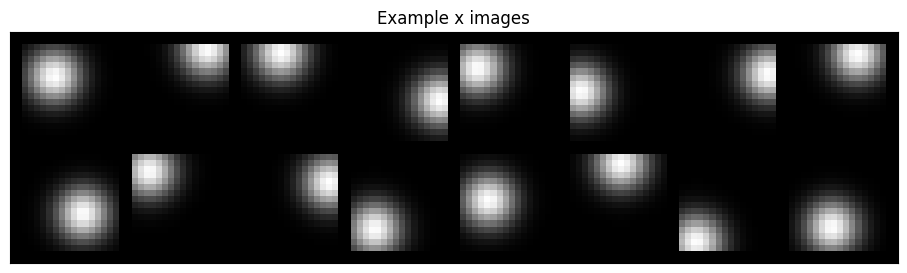

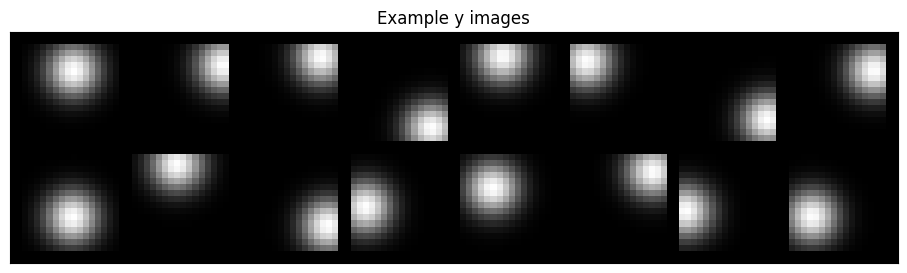

In [4]:

x_batch, y_batch = MI_pictures_obj.rvs(16)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(12, 3))
    for i, img in enumerate(imgs):
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), cmap='gray')
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

grid_x = torchvision.utils.make_grid(torch.tensor(x_batch).unsqueeze(1)).clip(0, 1)
grid_y = torchvision.utils.make_grid(torch.tensor(y_batch).unsqueeze(1)).clip(0, 1)

show(grid_x)
plt.title('Example x images')
plt.show()

show(grid_y)
plt.title('Example y images')
plt.show()



## Define the UNet backbone and InfoBridge module


In [5]:

unet_backbone = UNet2DModel(
    sample_size=image_shape[0],  
    in_channels=2,               
    out_channels=1,              
    layers_per_block=layers_per_block,
    block_out_channels=(n_features, n_features),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
    class_embed_type='timestep',
).to(device)

infobridge_model = InfoBridge(
    backbone=unet_backbone,
    eps=eps,
    lr=lr,
    t_eps=1e-5,
    nfe_posterior=100,
    base_mc_iters=1,
    default_batch_size=batch_size,
    ema_decay=ema_decay
).to(device)


## Prepare a training and validation datasets


In [6]:
x_train, y_train = MI_pictures_obj.rvs(n_train)

x0_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1).to(device)
x1_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

train_ds = TensorDataset(x0_train, x1_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

print(f"Train dataset shape: x0 {x0_train.shape}, x1 {x1_train.shape}")


Train dataset shape: x0 torch.Size([100000, 1, 16, 16]), x1 torch.Size([100000, 1, 16, 16])


In [7]:

x_eval, y_eval = MI_pictures_obj.rvs(n_eval)

x0_eval = torch.tensor(x_eval, dtype=torch.float32).unsqueeze(1).to(device)
x1_eval = torch.tensor(y_eval, dtype=torch.float32).unsqueeze(1).to(device)

print(f"Validation dataset shape: x0 {x0_eval.shape}, x1 {x1_eval.shape}")


Validation dataset shape: x0 torch.Size([10000, 1, 16, 16]), x1 torch.Size([10000, 1, 16, 16])


## Train InfoBridge


In [8]:

infobridge_model.fit(x0_train, x1_train, x0_eval, x1_eval, max_epochs=max_epochs, trainer_kwargs={"check_val_every_n_epoch": val_epoch_freq});


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone   │ UNet2DModel    │  1.7 M │ train │     0 │
│ 1 │ drift_plan │ DriftWrapper   │  1.7 M │ train │     0 │
│ 2 │ drift_ind  │ DriftWrapper   │  1.7 M │ train │     0 │
│ 3 │ bm_plan    │ BridgeMatching │  1.7 M │ train │     0 │
│ 4 │ bm_ind     │ BridgeMatching │  1.7 M │ train │     0 │
└───┴────────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 176                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:52<00:00, 14.89it/s, v_num=81, val_mi=4.940, loss_total=6.710]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:52<00:00, 14.84it/s, v_num=81, val_mi=4.940, loss_total=6.710]


InfoBridge(
  (backbone): UNet2DModel(
    (conv_in): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): LoRACompatibleLinear(in_features=64, out_features=256, bias=True)
      (act): SiLU()
      (linear_2): LoRACompatibleLinear(in_features=256, out_features=256, bias=True)
    )
    (class_embedding): TimestepEmbedding(
      (linear_1): LoRACompatibleLinear(in_features=64, out_features=256, bias=True)
      (act): SiLU()
      (linear_2): LoRACompatibleLinear(in_features=256, out_features=256, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
            (conv1): LoRACompatibleConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): LoRACompatibleLinear(in_features=256, out_features=64, bias=True)


In [11]:
infobridge_model.to(device);

## Estimate mutual information

Grow the `mc_iters` to enhance the stability of MI estimation


In [12]:

with torch.no_grad():
    mi_est = infobridge_model.estimate_mi(x0_eval, x1_eval, mc_iters=1)

print(f"Ground-truth MI: {mi_gt}")
print(f"Estimated MI (InfoBridge): {mi_est.item():.4f}")


Ground-truth MI: 5
Estimated MI (InfoBridge): 4.9284


## Sample from the learned bridge posterior

We can also visualize samples from the learned bridge, starting from `x0`.


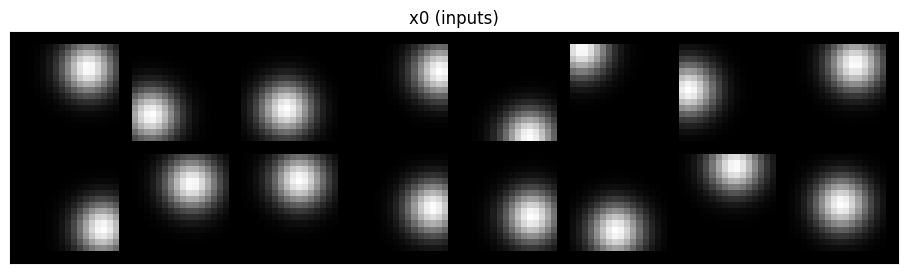

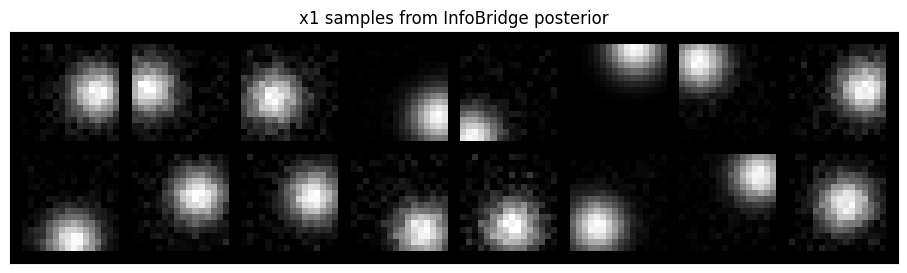

In [13]:

with torch.no_grad():
    x0_vis = x0_eval[:16]
    x1_samples = infobridge_model(x0_vis).cpu().clip(0, 1)

grid_x0 = torchvision.utils.make_grid(x0_vis.cpu())
grid_x1 = torchvision.utils.make_grid(x1_samples)

show(grid_x0)
plt.title('x0 (inputs)')
plt.show()

show(grid_x1)
plt.title('x1 samples from InfoBridge posterior')
plt.show()
